# < 다중분류 프로젝트 >
    
    1.정상/폐렴/Covid-19 데이터셋
    - https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/data
    
    2.데이터셋 준비하기
    - 텐서플로우 ImageDataGenerator.flow_from_directory() 사용

    3.데이터 전처리하기
    
    4.Pretrained-model 모델(VGG19 or Xception or MobileNetV2 등 ) 로드하기
    새로운 분류층 추가하기
    Compile 하기
    
    5.모델 학습하기
    
    6.모델 학습과정 살펴보기 (학습횟수에 따른 accuracy/loss 그래프 그리기)
    
    7.모델 평가 및 예측하기
    
    8.모델 예측 결과 출력(이미지+결과)하기 ( pred_label / true_label )
    
    9.모델 저장하기

## 1.정상/폐렴/Covid-19 데이터셋 소개

In [1]:
!gdown 1bO2zJTTtSspLpLn6HdUFrVREIm2gMYxr

Downloading...
From (original): https://drive.google.com/uc?id=1bO2zJTTtSspLpLn6HdUFrVREIm2gMYxr
From (redirected): https://drive.google.com/uc?id=1bO2zJTTtSspLpLn6HdUFrVREIm2gMYxr&confirm=t&uuid=538ef555-2730-4a1d-bec5-b0f269de7672
To: c:\Users\cooju\Documents\MyData\20_2024_KDT_대한상의\2025A_AI시스템반도체SW개발\07_딥러닝_CNN_실습예제_T\01_ImageClassification\covid_dataset.zip

  0%|          | 0.00/166M [00:00<?, ?B/s]
  0%|          | 524k/166M [00:00<01:09, 2.36MB/s]
  1%|          | 1.57M/166M [00:00<00:44, 3.71MB/s]
  2%|▏         | 2.62M/166M [00:00<00:31, 5.24MB/s]
  2%|▏         | 3.67M/166M [00:00<00:29, 5.41MB/s]
  3%|▎         | 4.72M/166M [00:00<00:25, 6.27MB/s]
  3%|▎         | 5.77M/166M [00:01<00:24, 6.65MB/s]
  4%|▍         | 6.82M/166M [00:01<00:22, 6.94MB/s]
  5%|▍         | 7.86M/166M [00:01<00:22, 7.01MB/s]
  5%|▌         | 8.91M/166M [00:01<00:22, 7.10MB/s]
  6%|▌         | 9.96M/166M [00:01<00:22, 7.05MB/s]
  7%|▋         | 11.0M/166M [00:01<00:21, 7.24MB/s]
  7%|▋         | 12.1

In [2]:
import zipfile

# zipfile.ZipFile() 사용하여 fer2013 하위폴더에 압축풀기
path = './covid_dataset.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')

# fer2013 하위폴더에 압축풀기
zip_object.extractall('./covid-19')
# close()하기
zip_object.close()

In [1]:
import tensorflow as tf
import numpy as np


In [ ]:

tf.keras.preprocessing.image.load_img('./covid-19/Covid19-dataset/train/Covid/01.jpeg')

In [2]:
img = tf.keras.preprocessing.image.load_img('./covid-19/Covid19-dataset/train/Covid/02.jpeg')
np.array(img).shape

(3480, 4248, 3)

## 2.데이터셋 준비하기 & 전처리하기

In [3]:
# 학습데이터셋 생성
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

train_generator = ImageDataGenerator(rotation_range=10,  # 이미지를 무작위로 회전시킬 최대 각도
                                     zoom_range=0.2,  # 이미지를 무작위로 확대/축소할 범위를 지정,1 - 0.2 = 0.8배에서 1 + 0.2 = 1.2배 사이의 무작위 스케일로 이미지를 확대 또는 축소
                                     horizontal_flip=True,  # 이미지를 수평 방향(좌우)으로 무작위로 뒤집기
                                     rescale=1/255)  # 이미지의 픽셀 값을 0에서 255의 범위에서 0에서 1의 범위로 정규화

train_dataset = train_generator.flow_from_directory(directory='./covid-19/Covid19-dataset/train',
                                                    target_size=(224, 224),  # 로드된 이미지의 크기를 조정할 대상의 크기, defaults to (256, 256)
                                                    class_mode='categorical', # one-hot 인코딩된 레이블을 반환, 다중 클래스 분류 문제 적합
                                                    batch_size=16,  # 한 번에 네트워크로 전달될 이미지의 수 (default: 32)
                                                    shuffle=True,  # 에포크마다 데이터를 섞을지 여부를 결정 (default: True) If set to False, sorts the data in alphanumeric order
                                                    seed=10)

Found 251 images belonging to 3 classes.


In [4]:
# 테스트에이터셋 생성
test_generator = ImageDataGenerator(rescale=1/255)

test_dataset = test_generator.flow_from_directory(directory='./covid-19/Covid19-dataset/test',
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=10)

Found 66 images belonging to 3 classes.


## 3.모델 구성하기- Pretrained-model모델 (MobileNetV2)

1. 특징 추출기 (Feature Extractor)
    - 여러 개의 Conv, BatchNorm, ReLU, Pooling 층 등
    - 입력 이미지로부터 **특징 맵(feature map)**을 추출하는 부분
    - include_top=False로 설정 시 이 부분만 남김

2. 분류기 (Classifier)
    - 보통 Flatten, Dense, Softmax 등으로 구성됨
    - 이미지넷 1000개 클래스 분류용이기 때문에 대부분의 사용자에겐 필요 없음
    - include_top=True일 경우 같이 포함됨

In [ ]:
# 모델 생성
input_shape = (224, 224, 3)  # MobileNetV2가 학습된 기본 크기 , 필요시 변경가능 input_shape = (500, 500, 3)


from tensorflow.keras import layers, Model  # Model을 여기서 가져옴
# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)

# # 상위 몇 개 층 동결 해제
# base_model.trainable = True
# for layer in base_model.layers[:-10]:
#     layer.trainable = False

In [ ]:
# Sequential API 방식
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAveragePooling2D(),  # 1차원으로로
                             tf.keras.layers.Dense(3, activation='softmax')])

# Functional API 방식
# inputs = tf.keras.Input(shape=(224, 224, 3))                      # 입력 정의
# x = base_model(inputs, training=False)                            # base_model에 입력 전달
# x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)                    # Conv2D
# x = tf.keras.layers.Dropout(0.2)(x)                                       # Dropout
# x = tf.keras.layers.GlobalAveragePooling2D()(x)                           # GAP
# outputs = tf.keras.layers.Dense(3, activation='softmax')(x)               # Dense (분류기)

# model = Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 2,626,755
Trainable params: 368,771
Non-tr

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 4.모델 학습하기

In [ ]:
epochs = 10
history = model.fit(train_dataset, epochs=epochs, 
                    validation_data=test_dataset,
                    steps_per_epoch=len(train_dataset),
                    validation_steps=len(test_dataset),
                    verbose=1)

Epoch 1/10
16/16 [==============================] - 13s 254ms/step - loss: 1.2184 - accuracy: 0.6056
Epoch 2/10
16/16 [==============================] - 4s 253ms/step - loss: 0.5720 - accuracy: 0.6733
Epoch 3/10
16/16 [==============================] - 4s 248ms/step - loss: 0.4909 - accuracy: 0.7450
Epoch 4/10
16/16 [==============================] - 4s 249ms/step - loss: 0.4586 - accuracy: 0.7610
Epoch 5/10
16/16 [==============================] - 4s 253ms/step - loss: 0.3943 - accuracy: 0.8327
Epoch 6/10
16/16 [==============================] - 4s 256ms/step - loss: 0.2727 - accuracy: 0.9243
Epoch 7/10
16/16 [==============================] - 4s 256ms/step - loss: 0.1780 - accuracy: 0.9522
Epoch 8/10
16/16 [==============================] - 4s 242ms/step - loss: 0.1507 - accuracy: 0.9283
Epoch 9/10
16/16 [==============================] - 4s 247ms/step - loss: 0.0763 - accuracy: 0.9721
Epoch 10/10
16/16 [==============================] - 4s 266ms/step - loss: 0.1100 - accuracy: 0.964

## 5.모델 학습과정 살펴보기

In [10]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


<Figure size 640x480 with 0 Axes>

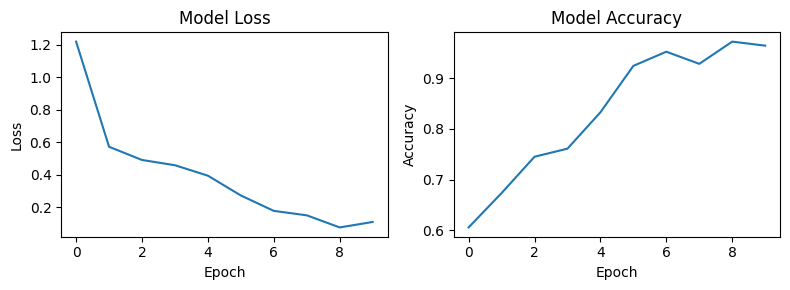

In [11]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(8,3))

# 훈련 손실 그래프
plt.subplot(121)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

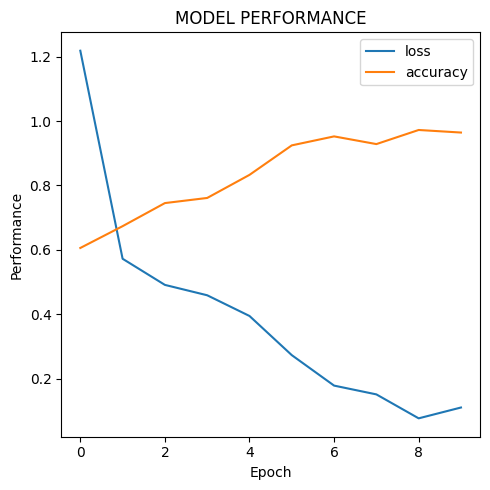

In [12]:
plt.clf()
plt.figure(figsize=(5,5))

# 훈련 손실, 정확도 그래프 한 눈에 보기
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('MODEL PERFORMANCE')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend(['loss', 'accuracy'], loc='upper right')

plt.tight_layout()
plt.show()

## 6.모델 평가 및 예측하기

In [17]:
!pip install pandas

  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)


In [13]:
preds = model.predict(test_dataset)
preds

66/66 [==============================] - 1s 8ms/step


array([[9.99980927e-01, 1.90649935e-05, 3.62343419e-11],
       [1.00000000e+00, 6.67888633e-10, 4.65936866e-14],
       [9.99861240e-01, 1.38768795e-04, 1.66199818e-08],
       [9.98813748e-01, 1.18532835e-03, 8.97806899e-07],
       [9.99891758e-01, 1.08247055e-04, 2.82924062e-09],
       [9.97627318e-01, 2.36874982e-03, 3.96354608e-06],
       [9.99966025e-01, 3.39328872e-05, 5.82461912e-10],
       [9.99999881e-01, 7.50119185e-08, 3.02253933e-09],
       [1.00000000e+00, 1.80642071e-10, 1.32144877e-11],
       [1.00000000e+00, 3.78009020e-08, 2.43789273e-08],
       [1.00000000e+00, 5.65323788e-09, 1.49795321e-09],
       [1.00000000e+00, 3.52108707e-08, 4.49103021e-09],
       [9.99739230e-01, 2.60739442e-04, 4.14876133e-08],
       [9.99434292e-01, 5.64386428e-04, 1.30524063e-06],
       [1.00000000e+00, 5.98913363e-09, 8.00818412e-10],
       [9.99999642e-01, 3.15920971e-07, 5.83422676e-12],
       [9.99999642e-01, 4.06640936e-07, 1.50267514e-08],
       [9.99999642e-01, 3.43654

In [14]:
preds = np.argmax(preds, axis=1)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1],
      dtype=int64)

In [15]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [18]:
import pandas as pd

df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
df_result['Actual'] = test_dataset.classes
df_result['Predicted'] = preds
df_result

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
61,2,1
62,2,2
63,2,2
64,2,2


In [20]:
!pip install -U scikit-learn

  Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl.metadata (15 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl (11.1 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(test_dataset.classes, preds)

0.9242424242424242

In [22]:
test_dataset.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

## 7.모델 예측 결과 출력(이미지+결과)하기

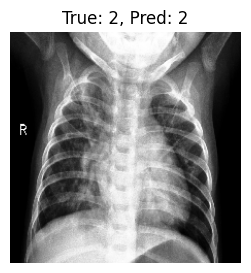

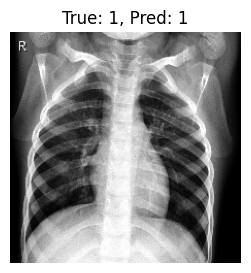

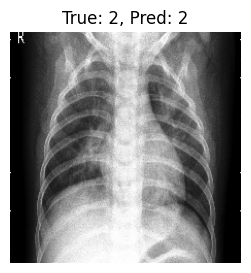

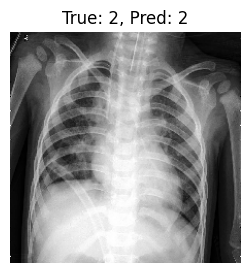

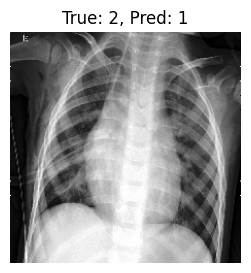

In [23]:
# 시각화할 이미지 개수
import matplotlib.pyplot as plt
num_images = 5
samples_to_display = np.random.choice(len(test_dataset), num_images, replace=False)

# 테스트 데이터 중 일부 이미지 시각화
for i, idx in enumerate(samples_to_display):
    img, label = test_dataset[idx]  # 이미지와 레이블을 가져옵니다
    img = img[0]  # 배치 차원 제거
    true_label = test_dataset.classes[idx]
    pred_label = preds[idx]
    plt.figure(figsize=(5, 3))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

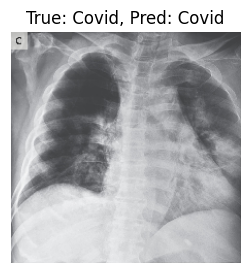

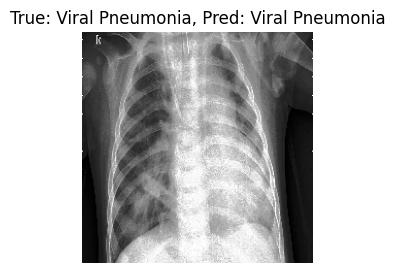

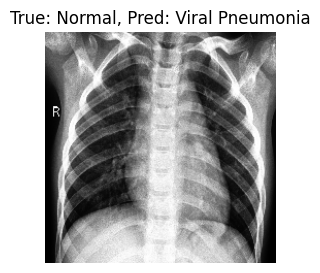

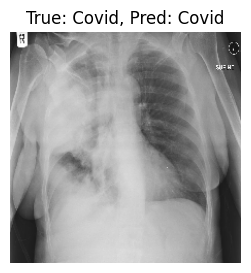

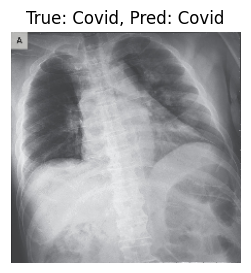

In [24]:
# 시각화할 이미지 개수
num_images = 5
#samples_to_display = np.random.choice(len(test_dataset), num_images, replace=False)
samples_to_display = np.random.choice(test_dataset.n, num_images, replace=False)

# 테스트 데이터 중 일부 이미지 시각화
for i, idx in enumerate(samples_to_display):
    # 데이터셋에서 이미지를 추출하려면, idx를 배치 인덱스와 위치 인덱스로 변환해야 합니다.
    batch_index = idx // test_dataset.batch_size
    img_index = idx % test_dataset.batch_size
    # 데이터 제너레이터에서 배치를 로드합니다.
    img_batch, label_batch = test_dataset[batch_index]
    img = img_batch[img_index].squeeze()  # 차원 축소
    true_label = np.argmax(label_batch[img_index])
    pred_label = preds[idx]

    plt.figure(figsize=(5, 3))
    plt.imshow(img, cmap='gray')
    # 클래스 인덱스를 클래스 이름으로 변환하여 표시합니다.
    plt.title(f"True: {list(test_dataset.class_indices.keys())[true_label]}, Pred: {list(test_dataset.class_indices.keys())[pred_label]}")
    plt.axis('off')
    plt.show()

## 8.모델 저장하기

In [22]:
from keras.models import save_model

# 모델 전체를 'model.h5' 파일로 저장
save_model(model, 'model.h5')

# 모델의 구조를 JSON 문자열로 반환-모델을 구성하는 각 레이어의 구성과 설정이 포함
with open('trained_model.json', 'w') as trained_model_json:
    trained_model_json.write(model.to_json())

# 모델 구조 로드하기
with open('trained_model.json', 'r') as trained_model_json:
    trained_model_json = trained_model_json.read()

# 모델 가중치 저장하기
save_model(model, './weights_emotions.hdf5')

# Load the trained model & weights
model = tf.keras.models.model_from_json(trained_model_json)
model.load_weights('./weights_emotions.hdf5')

## [전체 통합코드]

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Epoch 1/10
16/16 [==============================] - 20s 1s/step - loss: 1.9080 - accuracy: 0.5020
Epoch 2/10
16/16 [==============================] - 17s 1s/step - loss: 0.7098 - accuracy: 0.6135
Epoch 3/10
16/16 [==============================] - 17s 1s/step - loss: 0.5589 - accuracy: 0.6773
Epoch 4/10
16/16 [==============================] - 17s 1s/step - loss: 0.4245 - accuracy: 0.7331
Epoch 5/10
16/16 [==============================] - 17s 1s/step - loss: 0.3521 - accuracy: 0.8645
Epoch 6/10
16/16 [==============================] - 17s 1s/step - loss: 0.2289 - accuracy: 0.9522
Epoch 7/10
16/16 [==============================] - 17s 1s/step - loss: 0.1976 - accuracy: 0.9442
Epoch 8/10
16/16 [==============================] - 17s 1s/step - loss: 0.1271 - accuracy: 0.9681
Epoch 9/10
16/16 [==============================] - 17s 1s/step - loss: 0.1562 - accuracy: 0.9442
Epoch 10/10
66/66 [==================

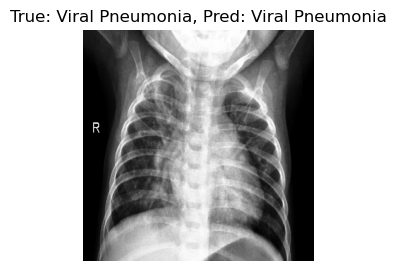

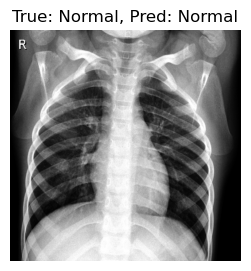

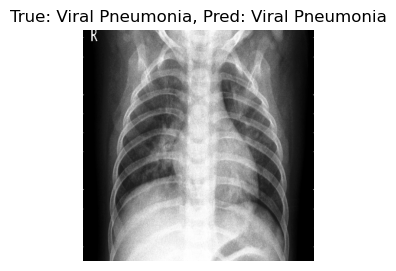

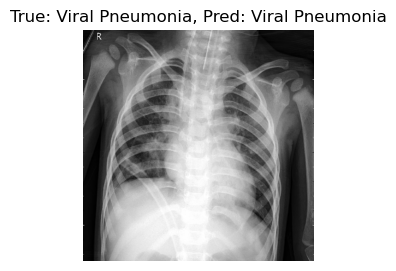

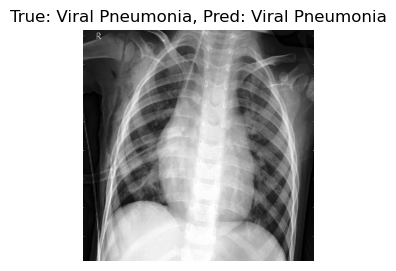

In [ ]:
import zipfile
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.models import save_model

# 1.정상/폐렴/Covid-19 데이터셋 (파일 압축 풀기)
path = './covid_dataset.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
# fer2013 하위폴더에 압축풀기
zip_object.extractall('./covid-19')
# close()하기
zip_object.close()


# 2. 데이터셋 준비하기
# 학습 데이터셋 생성
train_generator = ImageDataGenerator(rotation_range=10,  # 이미지를 무작위로 회전시킬 최대 각도
                                     zoom_range=0.2,  # 이미지를 무작위로 확대/축소할 범위를 지정,1 - 0.2 = 0.8배에서 1 + 0.2 = 1.2배 사이의 무작위 스케일로 이미지를 확대 또는 축소
                                     horizontal_flip=True,  # 이미지를 수평 방향(좌우)으로 무작위로 뒤집기
                                     rescale=1/255)  # 이미지의 픽셀 값을 0에서 255의 범위에서 0에서 1의 범위로 정규화
train_dataset = train_generator.flow_from_directory(directory='./covid-19/Covid19-dataset/train',
                                                    target_size=(224, 224),  # 로드된 이미지의 크기를 조정할 대상의 크기, defaults to (256, 256)
                                                    class_mode='categorical', # one-hot 인코딩된 레이블을 반환, 다중 클래스 분류 문제 적합
                                                    batch_size=16,  # 한 번에 네트워크로 전달될 이미지의 수 (default: 32)
                                                    shuffle=True,  # 에포크마다 데이터를 섞을지 여부를 결정 (default: True) If set to False, sorts the data in alphanumeric order
                                                    seed=10)
# 테스트 데이터셋 생성
test_generator = ImageDataGenerator(rescale=1/255)
test_dataset = test_generator.flow_from_directory(directory='./covid-19/Covid19-dataset/test',
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=10)


# 3.모델 생성(MobileNetV2)
input_shape = (224, 224, 3)
# MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(3, activation='softmax')])

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


# 4.학습하기
epochs = 10
model.fit(train_dataset, epochs=epochs)


# 5.모델 평가 및 예측
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=1)
accuracy_score(test_dataset.classes, preds)
print(accuracy_score)


# 6.결과 확인하기
num_images = 5
samples_to_display = np.random.choice(test_dataset.n, num_images, replace=False)


# 7.테스트 데이터 중 일부 이미지 시각화
for i, idx in enumerate(samples_to_display):
    # 데이터셋에서 이미지를 추출하려면, idx를 배치 인덱스와 위치 인덱스로 변환해야 합니다.
    batch_index = idx // test_dataset.batch_size
    img_index = idx % test_dataset.batch_size
    # 데이터 제너레이터에서 배치를 로드합니다.
    img_batch, label_batch = test_dataset[batch_index]
    img = img_batch[img_index].squeeze()  # 차원 축소
    true_label = np.argmax(label_batch[img_index])
    pred_label = preds[idx]

    plt.figure(figsize=(5, 3))
    plt.imshow(img, cmap='gray')
    # 클래스 인덱스를 클래스 이름으로 변환하여 표시합니다.
    plt.title(f"True: {list(test_dataset.class_indices.keys())[true_label]}, Pred: {list(test_dataset.class_indices.keys())[pred_label]}")
    plt.axis('off')
    plt.show()


# 8.모델 저장하기
# 모델 전체를 'model.h5' 파일로 저장
save_model(model, 'model.h5')

# 모델의 구조를 JSON 문자열로 반환-모델을 구성하는 각 레이어의 구성과 설정이 포함
with open('trained_model.json', 'w') as trained_model_json:
    trained_model_json.write(model.to_json())

# 모델 구조 로드하기
with open('trained_model.json', 'r') as trained_model_json:
    trained_model_json = trained_model_json.read()

# 모델 가중치 저장하기
save_model(model, './weights_emotions.hdf5')

# Load the trained model & weights
model = tf.keras.models.model_from_json(trained_model_json)
model.load_weights('./weights_emotions.hdf5')

In [5]:
# 1. 모든 사용 가능한 모델 확인
import tensorflow as tf

# 방법 1: 모든 모델 속성 확인
print("사용 가능한 모델들:")
for name in dir(tf.keras.applications):
    if not name.startswith('_') and name[0].isupper():
        print(f"- {name}")

# 방법 2: 더 구체적인 정보 출력
print("\n더 자세한 모델 정보:")
available_models = []
for attr_name in dir(tf.keras.applications):
    if not attr_name.startswith('_') and attr_name[0].isupper():
        try:
            module = getattr(tf.keras.applications, attr_name)
            if hasattr(module, '__doc__') and 'Instantiates' in str(module.__doc__):
                available_models.append(attr_name)
        except:
            pass

for model_name in available_models:
    print(f"- {model_name}")

# 2. 특정 모델의 구조 확인
print("\n모델 구조 확인 방법들:")

# 방법 1: model.summary() 사용
model = tf.keras.applications.MobileNetV2(weights=None)
print("\n1. model.summary():")
model.summary()

# 방법 2: 시각화 - 가장 읽기 쉬운 방법
from tensorflow.keras.utils import plot_model

# 간단한 다이어그램
plot_model(model, to_file='model_simple.png', show_shapes=True, show_layer_names=True)

# 상세한 다이어그램
plot_model(model, to_file='model_detailed.png', show_shapes=True, show_layer_names=True, 
           expand_nested=True, dpi=96)

# 3. 레이어별 상세 정보 확인
print("\n3. 레이어별 상세 정보:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    if hasattr(layer, 'output_shape'):
        print(f"  Output shape: {layer.output_shape}")
    if hasattr(layer, 'count_params'):
        print(f"  Parameters: {layer.count_params():,}")
    print()

# 4. 모델의 특정 정보 확인
print("\n4. 모델 정보:")
print(f"입력 shape: {model.input_shape}")
print(f"출력 shape: {model.output_shape}")
print(f"총 파라미터 수: {model.count_params():,}")
print(f"학습 가능한 파라미터 수: {sum([tf.math.count_nonzero(w) for w in model.trainable_weights]):,}")

# 5. 모델 설정 확인
print("\n5. 모델 설정:")
print(model.get_config())

# 6. 주요 모델들의 특징 비교
models_info = {
    'MobileNetV2': {'parameters': '3.5M', 'accuracy': '71.0%', 'size': '14MB'},
    'ResNet50': {'parameters': '25.6M', 'accuracy': '74.9%', 'size': '99MB'},
    'EfficientNetB0': {'parameters': '5.3M', 'accuracy': '77.1%', 'size': '20MB'},
    'VGG16': {'parameters': '138.4M', 'accuracy': '71.3%', 'size': '528MB'},
    'Xception': {'parameters': '22.9M', 'accuracy': '79.0%', 'size': '88MB'},
    'InceptionV3': {'parameters': '23.9M', 'accuracy': '77.9%', 'size': '92MB'},
    'DenseNet121': {'parameters': '8.1M', 'accuracy': '75.0%', 'size': '33MB'}
}

print("\n6. 주요 모델들의 특징 비교:")
print(f"{'Model':<15} {'Parameters':<12} {'Top-1 Acc':<12} {'Size':<8}")
print("-" * 50)
for model_name, info in models_info.items():
    print(f"{model_name:<15} {info['parameters']:<12} {info['accuracy']:<12} {info['size']:<8}")

# 7. 모델 인스턴스화 예제
print("\n7. 모델 인스턴스화 예제:")
examples = """
# EfficientNet 계열
model = tf.keras.applications.EfficientNetB0(weights='imagenet')

# ResNet 계열
model = tf.keras.applications.ResNet50(weights='imagenet')
model = tf.keras.applications.ResNet101V2(weights='imagenet')

# MobileNet 계열
model = tf.keras.applications.MobileNetV2(weights='imagenet')
model = tf.keras.applications.MobileNetV3Large(weights='imagenet')

# VGG 계열
model = tf.keras.applications.VGG16(weights='imagenet')
model = tf.keras.applications.VGG19(weights='imagenet')

# Inception 계열
model = tf.keras.applications.InceptionV3(weights='imagenet')
model = tf.keras.applications.InceptionResNetV2(weights='imagenet')

# DenseNet 계열
model = tf.keras.applications.DenseNet121(weights='imagenet')
model = tf.keras.applications.DenseNet201(weights='imagenet')

# Xception
model = tf.keras.applications.Xception(weights='imagenet')

# NASNet 계열
model = tf.keras.applications.NASNetMobile(weights='imagenet')
model = tf.keras.applications.NASNetLarge(weights='imagenet')
"""
print(examples)

# 8. 모델 레이어 구조 텍스트 출력
print("\n8. 모델 레이어 텍스트 트리:")
def print_model_tree(model, indent=0):
    for layer in model.layers:
        print("  " * indent + f"└─ {layer.__class__.__name__}: {layer.name}")
        # 서브 모델이 있는 경우
        if hasattr(layer, 'layers') and layer.layers:
            print_model_tree(layer, indent + 1)

print_model_tree(model)

# 9. 모델 비교 함수
def compare_models(model_names):
    """여러 모델들을 비교하는 함수"""
    comparison = []
    
    for name in model_names:
        try:
            # 모델 생성 (weights 없이)
            model_class = getattr(tf.keras.applications, name)
            model = model_class(weights=None, include_top=True)
            
            # 정보 수집
            info = {
                'name': name,
                'total_params': f"{model.count_params():,}",
                'input_shape': model.input_shape,
                'output_shape': model.output_shape,
                'layers': len(model.layers)
            }
            comparison.append(info)
            
            # 메모리 정리
            del model
            
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    return comparison

# 사용 예제
model_names = ['MobileNetV2', 'ResNet50', 'EfficientNetB0']
comparison_results = compare_models(model_names)

print("\n9. 모델 비교 결과:")
for result in comparison_results:
    print(f"\n{result['name']}:")
    print(f"  Parameters: {result['total_params']}")
    print(f"  Input shape: {result['input_shape']}")
    print(f"  Output shape: {result['output_shape']}")
    print(f"  Layers: {result['layers']}")

# 10. Jupyter Notebook에서 대화형 시각화
print("\n10. Jupyter Notebook에서 대화형 시각화:")
notebook_code = """
# Jupyter Notebook에서 실행
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

model = tf.keras.applications.MobileNetV2(weights=None)

# 간단한 다이어그램
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 상세한 다이어그램
SVG(model_to_dot(model, show_shapes=True, expand_nested=True).create(prog='dot', format='svg'))
"""
print(notebook_code)

사용 가능한 모델들:
- ConvNeXtBase
- ConvNeXtLarge
- ConvNeXtSmall
- ConvNeXtTiny
- ConvNeXtXLarge
- DenseNet121
- DenseNet169
- DenseNet201
- EfficientNetB0
- EfficientNetB1
- EfficientNetB2
- EfficientNetB3
- EfficientNetB4
- EfficientNetB5
- EfficientNetB6
- EfficientNetB7
- EfficientNetV2B0
- EfficientNetV2B1
- EfficientNetV2B2
- EfficientNetV2B3
- EfficientNetV2L
- EfficientNetV2M
- EfficientNetV2S
- InceptionResNetV2
- InceptionV3
- MobileNet
- MobileNetV2
- MobileNetV3Large
- MobileNetV3Small
- NASNetLarge
- NASNetMobile
- RegNetX002
- RegNetX004
- RegNetX006
- RegNetX008
- RegNetX016
- RegNetX032
- RegNetX040
- RegNetX064
- RegNetX080
- RegNetX120
- RegNetX160
- RegNetX320
- RegNetY002
- RegNetY004
- RegNetY006
- RegNetY008
- RegNetY016
- RegNetY032
- RegNetY040
- RegNetY064
- RegNetY080
- RegNetY120
- RegNetY160
- RegNetY320
- ResNet101
- ResNet101V2
- ResNet152
- ResNet152V2
- ResNet50
- ResNet50V2
- ResNetRS101
- ResNetRS152
- ResNetRS200
- ResNetRS270
- ResNetRS350
- ResNetRS420
- 